In [65]:
import numpy as np
import os
import pandas as pd
import inspect
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import gridspec

In [2]:
path = '/home/gantos/data/'
paths_LUNA_raw = [d for d in os.listdir(path) if 'subset' in d]
paths_LUNA_processed = [d for d in os.listdir(path) if 'voxels_' in d]
paths_Kaggle_raw = ['stage1','stage2']
paths_Kaggle_processed = [d for d in os.listdir(path) if 'arrays' in d]

In [3]:
def hist(ARRAY):
    plt.hist(ARRAY.flatten(), bins=80, color='c')
    plt.ylabel("Frequency")
    plt.show()

def array_stats(ARRAY):
    print ('Shape\t',ARRAY.shape)
    print ('Max\t',np.max(ARRAY))
    print ('Min\t',np.min(ARRAY))
    print ('Avg\t',np.mean(ARRAY))

In [4]:
def Kaggle_patients(PATH,DIRECTORIES):
    args,one,two,values = inspect.getargvalues(inspect.currentframe())
    for i in args:
        print ("%s = %s" % (i, values[i]))
    directory_to_patients = {}
    for directory in DIRECTORIES:
        patients = [f[:-4] for f in os.listdir(PATH+directory+'/')]
        patients = [f for f in patients if 'error' not in f]
        directory_to_patients[directory] = [f for f in patients if 'mins' not in f]
        
        print ('\tPatients in',directory,'..',len(directory_to_patients[directory]))
    print ('\tPatients TOTAL..',np.sum([len(d) for d in directory_to_patients.values()]))
    return directory_to_patients

In [5]:
def LUNA_patients(PATH,DIRECTORIES):
    args,one,two,values = inspect.getargvalues(inspect.currentframe())
    for i in args:
        print ("%s = %s" % (i, values[i]))
    directory_to_patients = {}
    for directory in DIRECTORIES:
        directory_to_patients[directory] = [f[:-4] for f in os.listdir(PATH+directory+'/') if '.mhd' in f]
        
        print ('\tPatients in',directory,'..',len(directory_to_patients[directory]))
    print ('\tPatients TOTAL..',np.sum([len(d) for d in directory_to_patients.values()]))
    return directory_to_patients

In [6]:
def LUNA_voxels(PATH,DIRECTORIES):
    df = pd.read_csv('../data/CSVFILES/annotations_enhanced.csv')
    args,one,two,values = inspect.getargvalues(inspect.currentframe())
    for i in args:
        print ("%s = %s" % (i, values[i]))
    
    directory_to_voxels = {}
    for directory in DIRECTORIES:
        print ('VOXELS..',directory.replace('voxels_','').replace('64',''))
        
        directory_to_voxels[directory] = {}
        IX_files = [f for f in os.listdir(PATH+directory+'/') if 'IX' in f]
        
        indices = []
        malignancies = []
        zeros = 0
        mals = 0
        for file in IX_files:
            IX = np.load(PATH+directory+'/'+file)
            indices.extend([i for i in IX if i>0])
            malignancies.extend([df['malignancy'][i] for i in IX if i>0])
            for i in IX:
                try:
                    df['malignancy'][i]
                    mals += 1
                except:
                    zeros += 1
        
        print ('\tMalignant voxels..',mals,"{0:.3f}%".format(mals/float(mals+zeros)))
        print ('\tNon-malignant voxels..',zeros,"{0:.3f}%".format(zeros/float(mals+zeros)))
        
        directory_to_voxels[directory][1] = mals
        directory_to_voxels[directory][0] = zeros
        directory_to_voxels[directory]['mal_IX'] = indices
        directory_to_voxels[directory]['mal_vals'] = malignancies
        
        hist(np.array(indices))
    
    return directory_to_voxels

In [7]:
Kaggle_patients_raw = Kaggle_patients(path,paths_Kaggle_raw)
Kaggle_patients_processed = Kaggle_patients(path,paths_Kaggle_processed)

PATH = /home/gantos/data/
DIRECTORIES = ['stage1', 'stage2']
	Patients in stage1 .. 1595
	Patients in stage2 .. 506
	Patients TOTAL.. 2101
PATH = /home/gantos/data/
DIRECTORIES = ['stage1_arrays', 'stage2_arrays']
	Patients in stage1_arrays .. 1434
	Patients in stage2_arrays .. 210
	Patients TOTAL.. 1644


In [8]:
def spacing_dicom(path):
    import dicom
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # The Image Position specifies the x, y, and z coords of the upper left hand corner of the image
    z_depths = [s.ImagePositionPatient[2] for s in slices]
    if len(set(z_depths))<len(z_depths):
        print ('Duplicate slices for same z-depth - ID:',path[-32:])
        slices.sort(key = lambda x: x.InstanceNumber)
        acq_num = int(np.mean([s.AcquisitionNumber for s in slices]))
        slices = [s for s in slices if s.AcquisitionNumber==acq_num]

    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    if slice_thickness == 0:
        print ('Patient with slice thickness of 0 - ID:',path[-32:])
        assert False     
    x,y = slices[0].ImagePositionPatient[:2]
    
    for s in slices:
        s.SliceThickness = slice_thickness
    
    spacing = np.array(slices[0].PixelSpacing + [slices[0].SliceThickness], dtype=np.float32)
        
    return spacing

In [ ]:
Kaggle_shapes = {}
for stage in Kaggle_patients_processed.keys():
    path_stage = path+stage[:6]+'/'
    print (path_stage)
    Kaggle_shapes[stage[:6]] = {}
    count = 0
    for patient in Kaggle_patients_processed[stage]:
        spacing = load_dicom(path_stage+patient)
        Kaggle_shapes[stage[:6]][patient] = spacing
        count += 1
        if count%100==0:
            print ('\t',count,'patient spacing stored in dictionary')
        

/home/gantos/data/stage1/
	 100 patient spacing stored in dictionary
Duplicate slices for same z-depth - ID: b8bb02d229361a623a4dc57aa0e5c485
	 200 patient spacing stored in dictionary
	 300 patient spacing stored in dictionary
	 400 patient spacing stored in dictionary
	 500 patient spacing stored in dictionary
	 600 patient spacing stored in dictionary
	 700 patient spacing stored in dictionary
	 800 patient spacing stored in dictionary
	 900 patient spacing stored in dictionary
	 1000 patient spacing stored in dictionary
	 1100 patient spacing stored in dictionary


In [15]:
import pickle
with open('./Kaggle_shapes.pickle', 'wb') as handle:
    pickle.dump(Kaggle_shapes, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ('Dictionary SAVED')

Dictionary SAVED


In [18]:
X,Y,Z = []
for stage in Kaggle_shapes.keys():
    for patient in Kaggle_shapes[stage].keys():
        

1434

In [35]:
stage1_shapes = np.vstack(Kaggle_shapes['stage1'].values())
stage2_shapes = np.vstack(Kaggle_shapes['stage2'].values())
all_shapes = pd.DataFrame(np.vstack((stage1_shapes,stage2_shapes)))
all_shapes.shape

(1644, 3)

In [36]:
all_shapes.describe()

,0,1,2
count,1644.000000,1644.000000,1644.000000
mean,0.666278,0.666278,1.854701
std,0.072425,0.072425,0.580547
min,0.488281,0.488281,0.625000
25%,0.615234,0.615234,1.500000
50%,0.664062,0.664062,2.000000
75%,0.703125,0.703125,2.500000
max,0.976562,0.976562,3.000000


In [66]:
data_boxplot_all = [np.array(all_shapes[i]) for i in list(all_shapes)]
data_boxplot_2 = data_boxplot_all[0:2]
data_boxplot_1 = data_boxplot_all[2:3]
data_labels_all = ['X','Y','Z']
data_labels_2 = data_labels_all[0:2]
data_labels_1 = data_labels_all[2:3]

In [233]:

fig = plt.figure(figsize=(10,10)) 
gs = gridspec.GridSpec(1,2,width_ratios=[2,1])
lw = 3

boxprops = dict(linestyle='-', linewidth=lw) #, color='darkgoldenrod')
meanlineprops = dict(linestyle='-', linewidth=lw+1) #, color='purple')
flierprops = dict(linestyle='-', linewidth=lw) #, color='purple')

ax0 = plt.subplot(gs[0])
bp_dict_2 = ax0.boxplot(data_boxplot_2,1,'o',0.75,showmeans=True, meanline=True,
                        boxprops=boxprops, meanprops=meanlineprops,showfliers=True)
for whisker in bp_dict_2['whiskers']:
    whisker.set(linewidth=lw)
for cap in bp_dict_2['caps']:
    cap.set(linewidth=lw)
ax0.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
xtickNames = plt.setp(ax0,xticklabels=np.repeat(data_labels_2,1))
plt.setp(xtickNames, fontsize=24)
plt.setp(bp_dict_2['medians'], linewidth=lw+1)
plt.rc('ytick',labelsize=24)

x_shift = [1.25,2.25,1.25,2.25]
x_shift_w = [1.25,1.25,2.25,2.25]
for line in bp_dict_2['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax0.text(x_shift[list(bp_dict_2['medians']).index(line)], y, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='orange')
for line in bp_dict_2['means']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax0.text(x_shift[list(bp_dict_2['means']).index(line)], y-0.1, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='green')

for line in bp_dict_2['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    ax0.text(x_shift[list(bp_dict_2['boxes']).index(line)],y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below
    x, y = line.get_xydata()[5] # bottom of right line
    ax0.text(x_shift[list(bp_dict_2['boxes']).index(line)],y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='top',
         fontsize=24)      # below
for line in bp_dict_2['caps']:
    x, y = line.get_xydata()[1] # bottom of left line
    ax0.text(x_shift_w[list(bp_dict_2['caps']).index(line)],y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below


ax1 = plt.subplot(gs[1])
bp_dict_1 = ax1.boxplot(data_boxplot_1,1,'o',0.75, showmeans=True, meanline=True,
                        boxprops=boxprops, meanprops=meanlineprops,showfliers=True)
for whisker in bp_dict_1['whiskers']:
    whisker.set(linewidth=lw)
for cap in bp_dict_1['caps']:
    cap.set(linewidth=lw)
ax1.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
xtickNames = plt.setp(ax1,xticklabels=np.repeat(data_labels_1,1))
plt.setp(xtickNames, fontsize=24)
plt.setp(bp_dict_1['medians'], linewidth=lw+1)
plt.rc('ytick',labelsize=24)

x_shift = 1.275
for line in bp_dict_1['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax1.text(x_shift, y, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='orange')
for line in bp_dict_1['means']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax1.text(x_shift, y, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='green')

for line in bp_dict_1['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    ax1.text(x_shift,y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below
#     x, y = line.get_xydata()[5] # bottom of right line
#     ax1.text(x_shift,y, '%.2f' % y,
#          horizontalalignment='center', # centered
#          verticalalignment='top',
#          fontsize=24)      # below
for line in bp_dict_1['caps']:
    x, y = line.get_xydata()[1] # bottom of left line
    ax1.text(x_shift,y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below

plt.tight_layout()
plt.savefig('./figs/Kaggle_Boxplot.png', transparent=True, bbox_inches='tight')

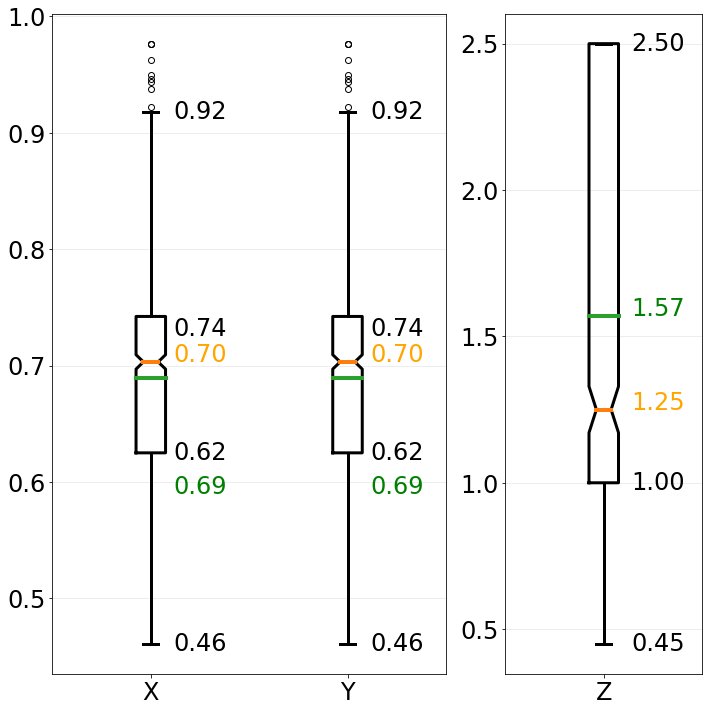

In [234]:
plt.show()

<img src="figs/Kaggle_Boxplot.png">

In [41]:
def shape_dicom(path):
    import dicom
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices = np.stack([s.pixel_array for s in slices],axis=2).astype(np.int16)
    
    return slices.shape

In [42]:
Kaggle_array_shapes = {}
for stage in Kaggle_patients_processed.keys():
    path_stage = path+stage[:6]+'/'
    print (path_stage)
    Kaggle_array_shapes[stage[:6]] = {}
    count = 0
    for patient in Kaggle_patients_processed[stage]:
        spacing = shape_dicom(path_stage+patient)
        Kaggle_array_shapes[stage[:6]][patient] = spacing
        count += 1
        if count%100==0:
            print ('\t',count,'patient spacing stored in dictionary')
        

/home/gantos/data/stage1/
	 100 patient spacing stored in dictionary
	 200 patient spacing stored in dictionary
	 300 patient spacing stored in dictionary
	 400 patient spacing stored in dictionary
	 500 patient spacing stored in dictionary
	 600 patient spacing stored in dictionary
	 700 patient spacing stored in dictionary
	 800 patient spacing stored in dictionary
	 900 patient spacing stored in dictionary
	 1000 patient spacing stored in dictionary
	 1100 patient spacing stored in dictionary
	 1200 patient spacing stored in dictionary
	 1300 patient spacing stored in dictionary
	 1400 patient spacing stored in dictionary
/home/gantos/data/stage2/
	 100 patient spacing stored in dictionary
	 200 patient spacing stored in dictionary


In [43]:
with open('./Kaggle_array_shapes.pickle', 'wb') as handle:
    pickle.dump(Kaggle_array_shapes, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ('Dictionary SAVED')

Dictionary SAVED


In [48]:
stage1_array_shapes = np.vstack(Kaggle_array_shapes['stage1'].values())
stage2_array_shapes = np.vstack(Kaggle_array_shapes['stage2'].values())
all_array_shapes = pd.DataFrame(np.vstack((stage1_array_shapes,stage2_array_shapes)))
all_array_shapes.shape

(1644, 3)

In [49]:
all_array_shapes.describe()

,0,1,2
count,1644.0,1644.0,1644.000000
mean,512.0,512.0,199.813260
std,0.0,0.0,103.889694
min,512.0,512.0,87.000000
25%,512.0,512.0,135.000000
50%,512.0,512.0,162.000000
75%,512.0,512.0,216.000000
max,512.0,512.0,615.000000


In [191]:
LUNA_patients_raw = LUNA_patients(path,paths_LUNA_raw)

PATH = /home/gantos/data/
DIRECTORIES = ['subset2', 'subset9', 'subset5', 'subset3', 'subset4', 'subset6', 'subset0', 'subset8', 'subset1', 'subset7']
	Patients in subset2 .. 89
	Patients in subset9 .. 88
	Patients in subset5 .. 89
	Patients in subset3 .. 89
	Patients in subset4 .. 89
	Patients in subset6 .. 89
	Patients in subset0 .. 89
	Patients in subset8 .. 88
	Patients in subset1 .. 89
	Patients in subset7 .. 89
	Patients TOTAL.. 888


In [192]:
LUNA_patients_processed = LUNA_voxels(path,paths_LUNA_processed)

PATH = /home/gantos/data/
DIRECTORIES = ['voxels_random64', 'voxels_false64', 'stage1_voxels_mask', 'voxels_true64', 'stage2_voxels_mask']
VOXELS.. random
	Malignant voxels.. 23 0.004%
	Non-malignant voxels.. 5305 0.996%
VOXELS.. false
	Malignant voxels.. 467 0.044%
	Non-malignant voxels.. 10189 0.956%
VOXELS.. stage1_mask


ZeroDivisionError: float division by zero

In [195]:
LUNA_patients_raw.keys():

dict_keys(['subset1', 'subset5', 'subset7', 'subset2', 'subset8', 'subset3', 'subset6', 'subset4', 'subset0', 'subset9'])

In [201]:
import SimpleITK as sitk

LUNA_shapes = {}
for subset in LUNA_patients_raw.keys():
    path_subset = path+subset+'/'
    print (path_subset)
    LUNA_shapes[subset] = {}
    count = 0
    for patient in LUNA_patients_raw[subset]:
        itkimage = sitk.ReadImage(path_subset+patient+'.mhd')
        img = sitk.GetArrayFromImage(itkimage)
        z,y,x = list(reversed(itkimage.GetSpacing()))
        LUNA_shapes[subset][patient] = [x,y,z,img.shape]
        count += 1
        if count%100==0:
            print ('\t',count,'patient spacing stored in dictionary')


/home/gantos/data/subset1/
/home/gantos/data/subset5/
/home/gantos/data/subset7/
/home/gantos/data/subset2/
/home/gantos/data/subset8/
/home/gantos/data/subset3/
/home/gantos/data/subset6/
/home/gantos/data/subset4/
/home/gantos/data/subset0/
/home/gantos/data/subset9/


In [204]:
LUNA_shapes['subset0'].keys()

dict_keys(['1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729', '1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326', '1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574', '1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196', '1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748', '1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843', '1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733', '1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557', '1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830', '1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227', '1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732', '1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987', '1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304', '1.3.6.1.4.1.14519.5.2.1.6279.6001.26

In [210]:
[l[0:3] for l in list(LUNA_shapes[subset].values())]

[[0.7617189884185791, 0.7617189884185791, 2.5],
 [0.6640620231628418, 0.6640620231628418, 1.25],
 [0.51953125, 0.51953125, 0.699999988079071],
 [0.5839840173721313, 0.5839840173721313, 2.5],
 [0.7480469942092896, 0.7480469942092896, 2.5],
 [0.76953125, 0.76953125, 1.0000001192092896],
 [0.56640625, 0.56640625, 1.7999999523162842],
 [0.78125, 0.78125, 2.5],
 [0.703125, 0.703125, 0.625],
 [0.703125, 0.703125, 0.625],
 [0.7421879768371582, 0.7421879768371582, 0.625],
 [0.703125, 0.703125, 2.5],
 [0.58984375, 0.58984375, 1.7999999523162842],
 [0.78125, 0.78125, 2.5],
 [0.7285159826278687, 0.7285159826278687, 1.25],
 [0.703125, 0.703125, 1.25],
 [0.5859379768371582, 0.5859379768371582, 2.0],
 [0.703125, 0.703125, 2.5],
 [0.703125, 0.703125, 0.625],
 [0.5664060115814209, 0.5664060115814209, 1.25],
 [0.546875, 0.546875, 1.0],
 [0.859375, 0.859375, 2.5],
 [0.6640620231628418, 0.6640620231628418, 2.5],
 [0.60546875, 0.60546875, 1.7999999523162842],
 [0.625, 0.625, 1.25],
 [0.6445310115814209, 0

In [211]:
subset_shapes = []
for subset in LUNA_shapes.keys():
    subset_shapes.append(np.vstack([l[0:3] for l in list(LUNA_shapes[subset].values())]))
LUNA_all_shapes = pd.DataFrame(np.vstack((subset_shapes)))
LUNA_all_shapes.shape

(888, 3)

In [212]:
data_boxplot_all = [np.array(LUNA_all_shapes[i]) for i in list(LUNA_all_shapes)]
data_boxplot_2 = data_boxplot_all[0:2]
data_boxplot_1 = data_boxplot_all[2:3]
data_labels_all = ['X','Y','Z']
data_labels_2 = data_labels_all[0:2]
data_labels_1 = data_labels_all[2:3]

In [249]:

fig = plt.figure(figsize=(10,10)) 
gs = gridspec.GridSpec(1,2,width_ratios=[2,1])
lw = 3

boxprops = dict(linestyle='-', linewidth=lw) #, color='darkgoldenrod')
meanlineprops = dict(linestyle='-', linewidth=lw+1) #, color='purple')
flierprops = dict(linestyle='-', linewidth=lw) #, color='purple')

ax0 = plt.subplot(gs[0])
bp_dict_2 = ax0.boxplot(data_boxplot_2,1,'o',0.75,showmeans=True, meanline=True,
                        boxprops=boxprops, meanprops=meanlineprops,showfliers=True)
for whisker in bp_dict_2['whiskers']:
    whisker.set(linewidth=lw)
for cap in bp_dict_2['caps']:
    cap.set(linewidth=lw)
ax0.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
xtickNames = plt.setp(ax0,xticklabels=np.repeat(data_labels_2,1))
plt.setp(xtickNames, fontsize=24)
plt.setp(bp_dict_2['medians'], linewidth=lw+1)
plt.rc('ytick',labelsize=24)

x_shift = [1.25,2.25,1.25,2.25]
x_shift_w = [1.25,1.25,2.25,2.25]
for line in bp_dict_2['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax0.text(x_shift[list(bp_dict_2['medians']).index(line)], y, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='orange')
for line in bp_dict_2['means']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax0.text(x_shift[list(bp_dict_2['means']).index(line)], y-0.003, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='green')

for line in bp_dict_2['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    ax0.text(x_shift[list(bp_dict_2['boxes']).index(line)],y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below
    x, y = line.get_xydata()[5] # bottom of right line
    ax0.text(x_shift[list(bp_dict_2['boxes']).index(line)],y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='top',
         fontsize=24)      # below
for line in bp_dict_2['caps']:
    x, y = line.get_xydata()[1] # bottom of left line
    ax0.text(x_shift_w[list(bp_dict_2['caps']).index(line)],y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below


ax1 = plt.subplot(gs[1])
bp_dict_1 = ax1.boxplot(data_boxplot_1,1,'o',0.75, showmeans=True, meanline=True,
                        boxprops=boxprops, meanprops=meanlineprops,showfliers=True)
for whisker in bp_dict_1['whiskers']:
    whisker.set(linewidth=lw)
for cap in bp_dict_1['caps']:
    cap.set(linewidth=lw)
ax1.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
xtickNames = plt.setp(ax1,xticklabels=np.repeat(data_labels_1,1))
plt.setp(xtickNames, fontsize=24)
plt.setp(bp_dict_1['medians'], linewidth=lw+1)
plt.rc('ytick',labelsize=24)

x_shift = 1.275
for line in bp_dict_1['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax1.text(x_shift, y, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='orange')
for line in bp_dict_1['means']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    ax1.text(x_shift, y, '%.2f' % y,
         horizontalalignment='center',
         verticalalignment='baseline',
         fontsize=24,color='green')

for line in bp_dict_1['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    ax1.text(x_shift,y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below

for line in bp_dict_1['caps']:
    x, y = line.get_xydata()[1] # bottom of left line
    ax1.text(x_shift,y, '%.2f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center',
         fontsize=24)      # below

plt.tight_layout()
plt.savefig('./figs/LUNA_Boxplot.png', transparent=True, bbox_inches='tight')

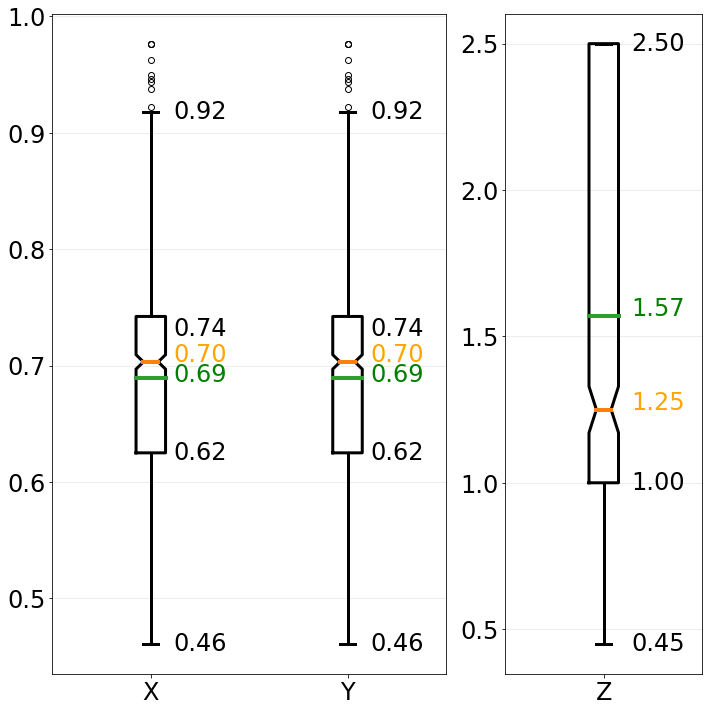

In [250]:
plt.show()

In [252]:
df_LUNA_shapes = pd.DataFrame([l[3] for l in list(LUNA_shapes[subset].values())])

In [254]:
df_LUNA_shapes.describe()

,0,1,2
count,89.000000,89.0,89.0
mean,278.168539,512.0,512.0
std,135.630450,0.0,0.0
min,95.000000,512.0,512.0
25%,143.000000,512.0,512.0
50%,253.000000,512.0,512.0
75%,368.000000,512.0,512.0
max,682.000000,512.0,512.0
